In [135]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import pickle

In [967]:
# Put csv into df
# df = pd.read_csv('data_from_same_step.csv')
df = pd.read_csv('data_same_timestep.csv')

In [968]:
df['user_lang']

KeyError: 'user_lang'

In [939]:
MU_MAX = 10e10
MU_MIN = 10e-10

class OriginalSimplifiedWickelgren:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_ = delta / (24 * 60 * 60)
        retention_rate_clipped = np.clip(retention_rate, 0.1, 0.9)
        return -1. * np.divide(np.log(1 + delta_), (np.log(retention_rate_clipped)))

    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_ = delta / (24 * 60 * 60)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1.,mu)
        return np.power(1. + delta_, exponent)

    @staticmethod
    def get_name():
        return "SWP"

    
class HLRSqrt:

    @staticmethod
    def calculate_mu(retention_rate, delta):
        delta_sqrt = np.sqrt(delta)
        retention_rate_clipped = np.clip(retention_rate, 0.001, 0.999)
        term = (-1 * delta_sqrt) / np.log2(retention_rate_clipped)
        mu = np.log2(term)
        return np.clip(mu+5, 5, MU_MAX)


    @staticmethod
    def calculate_retention_rate(mu, delta):
        delta_sqrt = np.sqrt(delta)
        mu = np.clip(mu, MU_MIN, MU_MAX)
        exponent = np.divide(-1 * delta_sqrt, np.power(2.,mu-5))
        return np.power(2., exponent)

    @staticmethod
    def get_name():
        return "HLR"
    
class MTR:
    def __init__(self):
        self.model = LinearRegression
        self.column_names = []
    
    def load(self):
        with open('model.pkl', 'rb') as file:
            self.model = pickle.load(file)
        
        with open('column_names.pkl', 'rb') as file:
            self.column_names = pickle.load(file)
    
    def predict_to_df(self, df):
        X = df[self.column_names]
        delta = df['delta']
        mu_pred = self.model.predict(X)
        df['score_pred'] = SimplifiedWickelgren.calculate_retention_rate(mu_pred, delta)
        return df
        
        

In [940]:
MAX_ELAPSED = 62208000
def engineer_features(X):
    for feature_name in X.columns:
        if 'seconds' in feature_name:
            mask = X[feature_name].where((0<X[feature_name]) & (X[feature_name]<MAX_ELAPSED))
            
            sqrt = np.sqrt(mask)
            X[feature_name+"_sqrt"] = np.nan_to_num(sqrt)

            inverse = np.clip(np.divide(1.0, mask), 10e-10, 10e-6)
            X[feature_name+"_inverse"] = np.nan_to_num(inverse)
            
            log_inverse = np.sqrt(inverse)
            X[feature_name+"_sqrt_inverse"] = np.nan_to_num(log_inverse)
            
            if 'FIRST_EXPOSURE' in feature_name:
                continue
                
            X.drop(feature_name, axis=1, inplace=True)
        if 'amount' in feature_name:
            X[feature_name+"_sqrt"] = np.sqrt(X[feature_name])
            X.drop(feature_name, axis=1, inplace=True)

    return X

In [941]:
df_ = df.loc[df['user_lang'] == 'charlie_de']
X = df_.drop(['score', 'delta', 'score_prev', 'user_lang'], axis=1)

# Save column names
X.sort_index(axis=1, inplace=True)
X = engineer_features(X)
X[X.columns] = MinMaxScaler().fit_transform(X)
X

,FIRST_EXPOSURE_seconds,ALL_amount_sqrt,ALL_leading_failures_amount_sqrt,ALL_leading_failures_seconds_sqrt,ALL_leading_failures_seconds_inverse,ALL_leading_failures_seconds_sqrt_inverse,ALL_leading_recalls_amount_sqrt,ALL_leading_recalls_seconds_sqrt,ALL_leading_recalls_seconds_inverse,ALL_leading_recalls_seconds_sqrt_inverse,...,TEXT__WORD_HIGHLIGHTED_seconds_inverse,TEXT__WORD_HIGHLIGHTED_seconds_sqrt_inverse,VIDEO__TRANSLATION_WAS_REVEALED_amount_sqrt,VIDEO__TRANSLATION_WAS_REVEALED_seconds_sqrt,VIDEO__TRANSLATION_WAS_REVEALED_seconds_inverse,VIDEO__TRANSLATION_WAS_REVEALED_seconds_sqrt_inverse,VIDEO__WAS_SEEN_amount_sqrt,VIDEO__WAS_SEEN_seconds_sqrt,VIDEO__WAS_SEEN_seconds_inverse,VIDEO__WAS_SEEN_seconds_sqrt_inverse
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10278,0.172612,0.002237,0.288675,0.052859,1.000000,1.000000,0.054108,0.211133,0.287074,0.535793,...,0.071516,0.267425,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10279,0.007078,0.000588,0.288675,0.164566,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.805393,0.897437,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10280,0.403738,0.000782,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.072460,0.269184,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20519,0.442254,0.004078,0.288675,0.190678,0.819189,0.905090,0.067828,0.110144,1.000000,1.000000,...,0.026361,0.162360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1017]:
# Separate features and label
# df_ = df.loc[df['user_lang'] == 'charlie_de']
df_ = df

# X = df_.drop(['score', 'delta', 'score_prev', 'user_lang'], axis=1)
X = df_.drop(['score', 'delta', 'score_prev'], axis=1)

# Save column names
X.sort_index(axis=1, inplace=True)
columns = X.columns
X = engineer_features(X)
# X[X.columns] = MinMaxScaler().fit_transform(X)

score = df_['score']
score_prev = df_['score_prev']
delta = df_['delta']
df_delta = pd.DataFrame({'delta': delta})
df_delta[df_delta.columns] = MinMaxScaler().fit_transform(df_delta)
delta_scaled = df_delta['delta']
# weights = 0.2 + np.power(np.multiply(1- score,delta_scaled),2)
weights = 0.1 + np.power(np.multiply(score - score_prev,delta_scaled),2)
# weights = None
# Calculate mu
mu = SimplifiedWickelgren.calculate_mu(score, delta)

# Fit for mu
model = LinearRegression()
model.fit(X, score, sample_weight=weights)
mu_pred = np.clip(model.predict(X), MU_MIN, MU_MAX)
score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta_scaled)
score_pred = mu_pred
# Save weights and intercepts

/home/charlie/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/tools.py:400: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


mu            6.463007
mu_pred       0.846522
score         0.848410
score_pred    0.505953
mae           0.389882
mse           0.250960
optimism     -0.342457
wmse          0.000106
dtype: float64

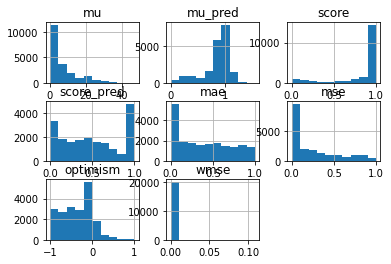

In [1018]:
mu_pred_2d = np.clip(model.predict(X), MU_MIN, MU_MAX)
mu_pred = mu_pred_2d.reshape(-1)
score_pred = SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)

wmse = np.power(np.multiply(np.multiply(score_prev- score,df_delta['delta']), score-score_pred), 2)
summary = pd.DataFrame({
    'mu': mu,
    'mu_pred': mu_pred,
    'score': score,
    'score_pred': score_pred,
    'mae': np.abs(score-score_pred),
    'mse': np.multiply((score-score_pred), (score-score_pred)),
    'optimism': score_pred-score,
    'wmse': wmse
})
summary.hist()
summary.mean()

<AxesSubplot:>

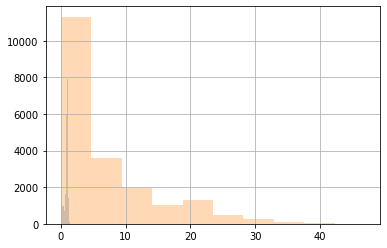

In [1019]:
summary['mu_pred'].hist(alpha=0.3)
summary['mu'].hist(alpha=0.3)

<AxesSubplot:xlabel='score', ylabel='score'>

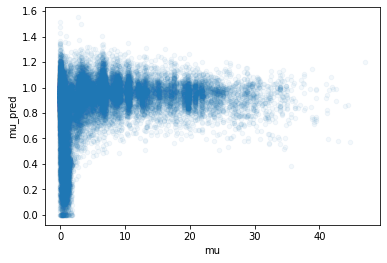

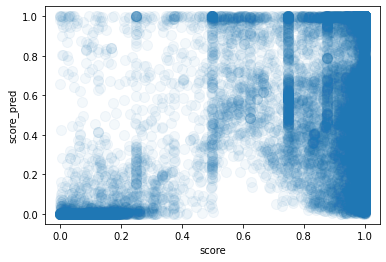

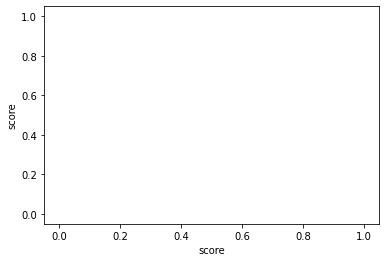

In [1020]:
summary.plot.scatter(x='mu', y='mu_pred', alpha=0.05)
summary.plot.scatter(x='score', y='score_pred', s=100, alpha=0.05)
summary.plot.scatter(x='score', y='score', s=100, alpha=0.001)
# summary['score_pred'].hist()
# summary['score'].hist()

In [953]:
# Save columns
with open('column_names.pkl', 'wb') as file:
    pickle.dump(columns, file)

# Save model
# with open('model.pkl', 'wb') as file:
#     pickle.dump(model, file)


In [1035]:
# Neural network
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

from tensorflow.keras.layers import Input, Dense, Layer, BatchNormalization
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanSquaredError
general_input = Input(shape=[len(X.columns)])
general_hidden_1 = Dense(20, activation="relu")(general_input)
# general_hidden_5 = Dense(15, activation="sigmoid")(general_hidden_1)
# general_hidden_3 = Dense(15, activation="relu")(general_hidden_2)
# general_hidden_4 = Dense(15, activation="relu")(general_hidden_3)
# general_hidden_5 = Dense(8, activation="relu")(general_hidden_4)
general_hidden_last = Dense(10, activation='relu')(general_hidden_1)
general_output = Dense(1)(general_hidden_last)
# general_output = Dense(1, activation='exponential')(general_output_pre)
model = Model(inputs=[general_input], outputs=[general_output,])
# Get data
# model.fit(X, mu, epochs=1000, batch_size=100, sample_weight=weights)

In [1036]:
model.compile(loss='mse', optimizer="adam", metrics=['mse'])
for i in range(300):
    model.fit(X_scaled, mu, epochs=1, batch_size=100, sample_weight=weights)
#     model.fit(X, mu, epochs=1, batch_size=100)
    mu_pred_2d = np.clip(model.predict(X_scaled), MU_MIN, MU_MAX)
    mu_pred = mu_pred_2d.reshape(-1)
    summary = pd.DataFrame({
    'mu': mu,
    'mu_pred': mu_pred,
    'score': score,
    'score_pred': SimplifiedWickelgren.calculate_retention_rate(mu_pred,delta)
    })
    ax = summary.plot.scatter(x='mu', y='mu_pred', s=100, alpha=0.1)
    ax.get_figure().savefig(f'plots/mu{str(i).zfill(3)}.png')
    ax = summary.plot.scatter(x='score', y='score_pred', s=100, alpha=0.1)
    ax.get_figure().savefig(f'plots/score{str(i).zfill(3)}.png')


201/201 [==============================] - 0s 1ms/step - loss: 2.4960 - mse: 24.2151


/home/charlie/.local/lib/python3.9/site-packages/pandas/plotting/_matplotlib/core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


201/201 [==============================] - 0s 1ms/step - loss: 1.5789 - mse: 15.6448


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7fe488408280> (for post_execute):


KeyboardInterrupt: 

In [1016]:
model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model/assets


In [1037]:
with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [1039]:
with open('scaler.pkl', 'rb') as file:
    scaler = pickle.load(file)
scaler.transform

<bound method MinMaxScaler.transform of MinMaxScaler()>